In [1]:
import numpy as np
import pandas as pd
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingClassifier

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Displaying all columns and rows 
pd.options.display.max_columns = 10000
pd.options.display.max_rows = 10000000

# 1. Importing Data

In [2]:
train = pd.read_csv("train.csv") 
valid = pd.read_csv("validation.csv") 

In [8]:
train.head()

,click,weekday,hour,bidid,userid,useragent,IP,region,city,adexchange,domain,url,urlid,slotid,slotwidth,slotheight,slotvisibility,slotformat,slotprice,creative,bidprice,payprice,keypage,advertiser,usertag
0,0,5,22,b7bea80521fdecd95d2d761a38c91c3f09618066,2e880fb7d690cf7377b2e42e701728e3f3c0e4c1,windows_ie,125.37.175.*,2,2,2.0,trqRTvKaXTKfgg24JKTI,6447a7dfa30fe6eb410c91860e7c9b45,NaN,2015392487,200,200,2,0,5,a4f763f78ef3eedfe614263b94a8924e,238,5,0f951a030abdaedd733ee8d114ce2944,3427,NaN
1,0,1,20,4f51205475678f5a124bc76b2c54163bf8eaa7eb,3a1fe01360ff8100e7d006b83b77a3e4c01d928c,windows_chrome,171.36.92.*,238,239,1.0,20fc675468712705dbf5d3eda94126da,3ddf173a94bd23c326683b6373c75dd4,NaN,mm_10982364_973726_8930541,300,250,FourthView,Na,0,10722,294,23,NaN,2821,NaN
2,0,3,13,b604e3fd054a658ab7ced4285ebf2ef54d2bd890,801d18a056b6fe6b06a794aef17fb0d6daff2414,windows_ie,59.46.106.*,40,41,2.0,trqRTJn7O95I1mKYUV,625d1b5916ea925332c7b326c0574cfa,NaN,1720123646,250,250,2,0,5,798b2d49952d77f1eace9f23c210d0b5,238,24,0f951a030abdaedd733ee8d114ce2944,3427,"10052,10006,13866,10110"
3,0,6,23,0348beeae93e561584c3b50fc9e7746a33048ad7,0d6eaf2259699990e38a1fc5116f112070b9ecdc,windows_ie,114.250.226.*,1,1,1.0,5F97t5E0BTK7XhNrUMpENpn,dedc488b98ca20707bc9a723957e7d1f,NaN,mm_10027070_118039_10308280,160,600,2,1,0,cb7c76e7784031272e37af8e7e9b062c,300,25,bebefa5efe83beee17a3d245e7c5085b,1458,"13866,10063,10111"
4,0,5,6,268149c1789bce2bc9798ffd97ec431219bafeb3,a239d9bb642460d974ba67f85e63b8d3e214da0e,windows_ie,183.63.192.*,216,233,2.0,13625cb070ffb306b425cd803c4b7ab4,4199d1227c511fc776b76594dabff9f8,NaN,1120200150,728,90,OtherView,Na,133,7330,277,133,NaN,2259,NaN


In [9]:
#train.shape

In [10]:
#valid.head()

In [11]:
#valid.shape

Testing set does not have click, bidprice and payprice

# 2. Data Pre-Processing

In [ ]:
def preprocess(data, enforce_cols=None):
    ############### Handling useragent ################
    useragent_data= data['useragent'].str.split("_", n = 1, expand = True) 
    data['agent']= useragent_data[0] 
    data['browser']= useragent_data[1] 
    data.drop(columns =['useragent'], inplace = True) 
    
    ############# Computing a New Varialbe: slotsize ###############
    data['slotsize']=data.slotwidth*data.slotheight
    
    ############# Computing New Categorical Variables ###############
    data.ix[data.hour.between(0, 3), 'hour_'] = 1
    data.ix[data.hour.between(4, 7), 'hour_'] = 2
    data.ix[data.hour.between(8, 11), 'hour_'] = 3
    data.ix[data.hour.between(12, 15), 'hour_'] = 4
    data.ix[data.hour.between(16, 19), 'hour_'] = 5
    data.ix[data.hour.between(20, 23), 'hour_'] = 6
    data['hour_'] = data['hour_'].astype(np.uint8)
    
    data.ix[data.slotprice.between(0, 18), 'slotprice_'] = 1
    data.ix[data.slotprice.between(19, 67), 'slotprice_'] = 2
    data.ix[data.slotprice.between(68, 309), 'slotprice_'] = 3
    data.ix[data.slotprice.between(309, 1000000), 'slotprice_'] = 4
    data['slotprice_'] = data['slotprice_'].astype(np.uint8)
    
    ############## Dummy Coding ####################
    data = data.replace('Na',np.nan)
    data_dummy = pd.get_dummies(data, columns=['weekday','region','city','adexchange',
                                               'slotvisibility','slotformat','keypage',
                                               'advertiser','agent','browser','slotsize','slotprice_','hour_'
                                              ])

    ############# Drop Unwanted Variables ################
    data_dropped = data_dummy.drop(columns=['click','bidid', 'userid', 'IP','domain','url','urlid','slotid','bidprice',
                                            'payprice','slotheight','slotwidth','slotprice','hour','creative'])
    
    ############ Fill in NaNs with 0s #############
    data_na=data_dropped.fillna('0')
    
    ############ Handling usertag ################
    # Create a dataframe spliting usertag into variables and count
    usertag_= data_na.usertag.str.replace(',',' ')
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(usertag_)
    usertag_data = pd.DataFrame(data=X.toarray(), columns=vectorizer.get_feature_names())
    # Combining the usertag dataframe with the original dataframe
    data_final = pd.concat([data_na, usertag_data],sort=True,axis=1)
    data_final = data_final.drop(columns=['usertag'])
    
    ###### Matching the number of variables in the validation set with the training set ######
    #""""Reference: DrivenDataLabs, 2017, BENCHMARK FOR POVER-T TEST - PREDICTING POVERTY
        #url: http://drivendata.co/blog/worldbank-poverty-benchmark/""""
    if enforce_cols is not None:
        drop = np.setdiff1d(data_final.columns, enforce_cols)
        add = np.setdiff1d(enforce_cols, data_final.columns)

        data_final.drop(drop, axis=1, inplace=True)
        data_final = data_final.assign(**{c: 0 for c in add})
    
    print(data_final.shape)
    
    return data_final

In [ ]:
train_new = preprocess(train)
valid_new = preprocess(valid,enforce_cols=train_new.columns)
valid_new = valid_new[train_new.columns]

In [ ]:
y = train['click']
y_val = valid['click']

# 3. Train Model

## 3.1 Treating imbalanced data

In [ ]:
# Separate click and unclick
resample_num = pd.to_numeric(train['click'])
resample_data = pd.concat([resample_num, train_new],axis=1)

df_majority = resample_data[resample_data.click==0]
df_minority = resample_data[resample_data.click==1]
 
# Downsample unclick
size=int((len(y)-sum(y))*0.03)
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=size,  # ratio
                                 random_state=1) # reproducible results

# Combine 
downsampled = pd.concat([df_majority_downsampled, df_minority])
 
downsampled.click.value_counts()

In [ ]:
# Separate into features and target variable
y_new = downsampled.click
x_new = downsampled.drop('click', axis=1)

In [11]:
#print(y_new.shape)
#print(x_new.shape)

## 3.2 Logistic Regression

In [16]:
best_LR = LogisticRegression(penalty='l1', C=0.1, class_weight='unbalanced', random_state=3, solver='saga')

best_LR.fit(x_new, y_new)

y_valid_p = best_LR.predict_proba(valid_new)
print('Area Under ROC Curve:',round(roc_auc_score(y_val, y_valid_p[:,1]),3))

Area Under ROC Curve: 0.826


In [ ]:
#average CTR
avgCTR = sum(y)/len(y)

#validation pCTR
pCTR_valid_before = y_valid_p[:,1]
pCTR_valid = pCTR_valid_before / (pCTR_valid_before +(1-pCTR_valid_before)/0.03)

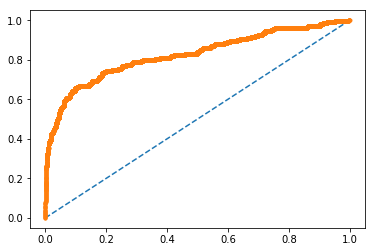

In [17]:
fpr, tpr, thresholds = roc_curve(y_val, y_valid_p[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

## 3.3 Gradient Boosting Classifier (GBC)

In [ ]:
gbc = ensemble.GradientBoostingClassifier(**{'n_estimators': 250, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.05, 'loss': 'deviance'})
gbc.fit(x_new, y_new)
pred_y_gbc = gbc.predict_proba(valid_new)

In [ ]:
auc1=roc_auc_score(y_val, pred_y_gbc[:,1])

In [22]:
print(auc1)

0.8802152091227731


In [ ]:
#average CTR
avgCTR = sum(y)/len(y)

#validation pCTR
pCTR_valid_gbc_before = pred_y_gbc[:,1]
pCTR_valid_gbc = pCTR_valid_gbc_before / (pCTR_valid_gbc_before +(1-pCTR_valid_gbc_before)/0.03)

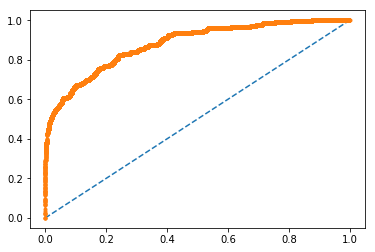

In [23]:
fpr, tpr, thresholds = roc_curve(y_val, pred_y_gbc[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
#plt.savefig('Q4.png',dpi=300)
plt.show()

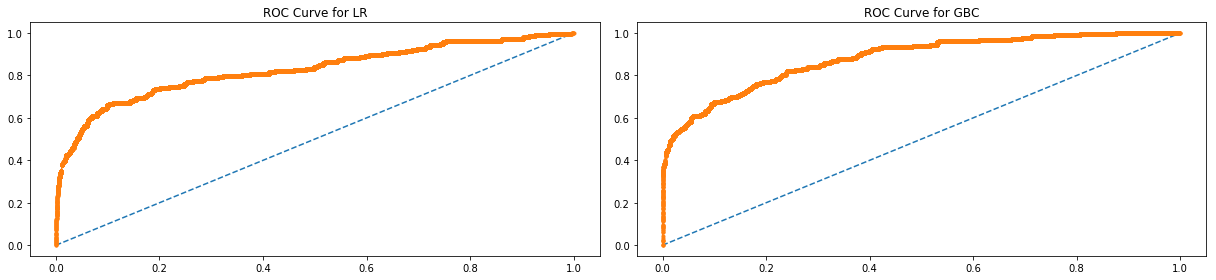

In [24]:
fig, (ax1, ax2)=plt.subplots(1,2,figsize=(17,4))

fpr, tpr, thresholds = roc_curve(y_val, y_valid_p[:,1])
ax1.plot([0, 1], [0, 1], linestyle='--')
ax1.plot(fpr, tpr, marker='.')
ax1.set_title("ROC Curve for LR")

fpr1, tpr1, thresholds1 = roc_curve(y_val, pred_y_gbc[:,1])
ax2.plot([0, 1], [0, 1], linestyle='--')
ax2.plot(fpr1, tpr1, marker='.')
ax2.set_title("ROC Curve for GBC")
plt.savefig('ROC ALL.png',dpi=300)
plt.tight_layout()

# 4. Bidding

## 4.1 Bidding Mechanism

In [18]:
def bidding(bidprice):
    budget = 6250
    imps = 0
    click = 0
    for i in range(0, len(valid)):
        if budget < valid.payprice[i]/1000:
            continue
        if bidprice[i] >= valid.payprice[i]:
            budget = budget - valid.payprice[i]/1000
            imps += 1
            if valid.click[i]==1:
                click += 1
    
    click = click
    imps = imps
    CTR = click/imps
    spend = 6250-budget
    CPM = spend/imps
    eCPC = spend/click
    
    return click, imps, spend, CTR, CPM, eCPC

## 4.2  LR + Linear

In [26]:
linear = pd.DataFrame(columns = ['Base_Bid','Imps','Click','Spend','CTR','CPM','eCPC'])
iteration = 0
for i in np.arange(3,300,3):
    iteration += 1
    base_bid = i
    #linear strategy inputs to get bid price 
    bid = base_bid * pCTR_valid/avgCTR
    #bidding mechanism
    click, imps, spend, CTR, CPM, eCPC = bidding(bid)
    #feeding data into a dataframe
    linear.loc[iteration,'Base_Bid'] = base_bid
    linear.loc[iteration,'Imps'] = imps
    linear.loc[iteration,'Click'] = click
    linear.loc[iteration,'Spend'] = round(spend,2)
    linear.loc[iteration,'CTR'] = round(CTR,5)
    linear.loc[iteration,'CPM'] = round(CPM*1000,2)
    linear.loc[iteration,'eCPC'] = round(eCPC,2)

In [27]:
linear.head()

,Base_Bid,Imps,Click,Spend,CTR,CPM,eCPC
1,3,2709,37,54.69,0.01366,20.19,1.48
2,6,6115,55,143.04,0.00899,23.39,2.6
3,9,10304,61,254.37,0.00592,24.69,4.17
4,12,14542,75,382.21,0.00516,26.28,5.1
5,15,18552,82,518.67,0.00442,27.96,6.33


In [28]:
linear.iloc[np.where(linear.Click == linear.Click.max())[0]]

,Base_Bid,Imps,Click,Spend,CTR,CPM,eCPC
29,87,122027,157,5621.86,0.00129,46.07,35.81
30,90,125817,157,5858.79,0.00125,46.57,37.32
31,93,129471,157,6102.02,0.00121,47.13,38.87


## 4.3 GBC + Linear

In [53]:
linear1 = pd.DataFrame(columns = ['Base_Bid','Imps','Click','Spend','CTR','CPM','eCPC'])
iteration = 0
for i in np.arange(3,300,3):
    iteration += 1
    base_bid = i
    #linear strategy inputs to get bid price 
    bid = base_bid * pCTR_valid_gbc/avgCTR
    #bidding mechanism
    click, imps, spend, CTR, CPM, eCPC = bidding(bid)
    #feeding data into a dataframe
    linear1.loc[iteration,'Base_Bid'] = base_bid
    linear1.loc[iteration,'Imps'] = imps
    linear1.loc[iteration,'Click'] = click
    linear1.loc[iteration,'Spend'] = round(spend,2)
    linear1.loc[iteration,'CTR'] = round(CTR,5)
    linear1.loc[iteration,'CPM'] = round(CPM*1000,2)
    linear1.loc[iteration,'eCPC'] = round(eCPC,2)

In [54]:
linear1.head()

,Base_Bid,Imps,Click,Spend,CTR,CPM,eCPC
1,3,2699,74,72.87,0.02742,27,0.98
2,6,4965,83,135.23,0.01672,27.24,1.63
3,9,7880,83,206.23,0.01053,26.17,2.48
4,12,10665,87,279.17,0.00816,26.18,3.21
5,15,13656,93,363.26,0.00681,26.6,3.91


In [55]:
linear1.iloc[np.where(linear1.Click == linear1.Click.max())[0]]

,Base_Bid,Imps,Click,Spend,CTR,CPM,eCPC
45,135,138249,162,6179.74,0.00117,44.7,38.15


## ------------------ Comparison Between LR and GBC ----------------------

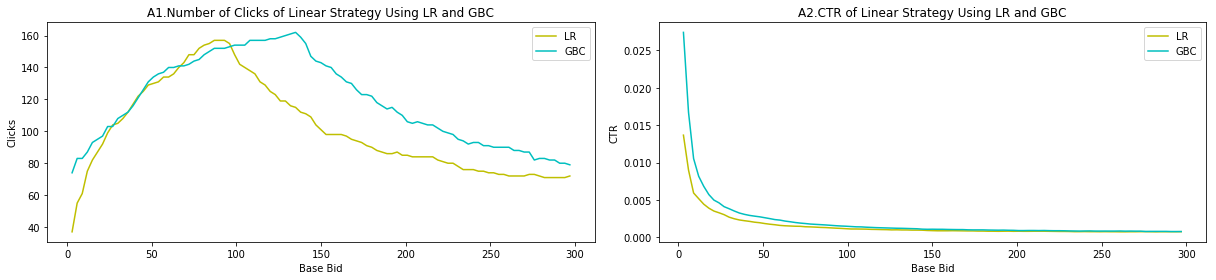

In [62]:
fig, (ax1, ax2)=plt.subplots(1,2, figsize = (17,4))
ax1.plot(linear.Base_Bid,linear.Click,color='y',label='LR')
ax1.set_ylabel('Clicks')
ax1.set_xlabel('Base Bid')
ax1.plot(linear1.Base_Bid, linear1.Click, color='c',label='GBC')
ax1.legend()
ax1.set_title("A1.Number of Clicks of Linear Strategy Using LR and GBC")

ax2.plot(linear.Base_Bid,linear.CTR,color='y',label='LR')
ax2.set_ylabel('CTR')
ax2.set_xlabel('Base Bid')
ax2.plot(linear1.Base_Bid, linear1.CTR, color='c',label='GBC')
ax2.legend()
ax2.set_title("A2.CTR of Linear Strategy Using LR and GBC")

plt.tight_layout()
plt.savefig('LRGBCLS.png',dpi=300)